In [1]:
import sys
sys.path.append('../')

from low_rank_rnns.test_modules_vanilla import *

from low_rank_rnns import TF, stats, plotting as plot, helpers, rankone, ranktwo, clustering

from matplotlib import pyplot as plt
# %matplotlib notebook



In [2]:
size = 100
noise_std = 1e-2
alpha = .1
lr = 1e-3

# noise_std = 5e-2
# alpha = .2
# lr = 1e-2

In [3]:
x_train, y_train, mask_train, cohAll_train, x_val, y_val, mask_val, cohAll_val = TF.generate_checker_data(5000)
net = FullRankRNN(3, size, 1, noise_std, alpha, train_wi=True, train_wo = True, train_h0=True)


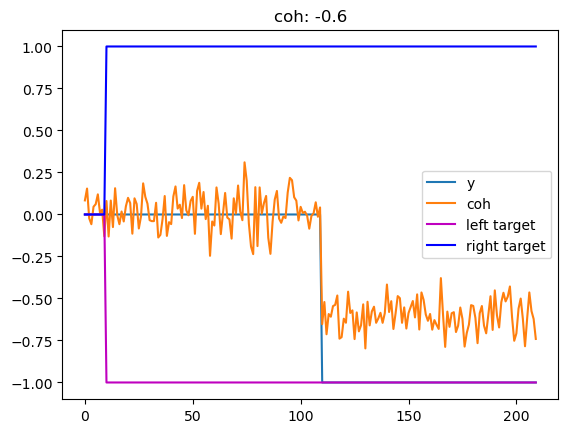

In [4]:
n = 8

plt.plot(y_val[n,:,:], label = 'y')
plt.plot(x_val[n,:,0], label = 'coh')
plt.plot(x_val[n,:,1], 'm', label = 'left target')
plt.plot(x_val[n,:,2], 'b', label = 'right target')
plt.title('coh: ' + str(cohAll_val[n]))
plt.legend()





# train a full-rank RNN

In [5]:


net.non_linearity = torch.relu

train(net, x_train, y_train, mask_train, n_epochs=20, lr=lr / sqrt(size), batch_size=50, keep_best=True, cuda=True, early_stop=0.2)

x_val, y_val, mask_val = map_device([x_val, y_val, mask_val], net)

# will only choose 1 of the 2  
# out = net.forward(x_val)
loss, acc, out, decisions, target_decisions, traj = TF.test_checker(net, x_val, y_val, mask_val)
print(f'loss={loss:.3f}, acc={acc:.3f}')

# save the model
# torch.save(net.state_dict(), f'../models/TF{size}.pt')

Training...
initial loss: 0.999
epoch 0:  loss=0.980  (took 10.01 s) *
epoch 1:  loss=0.888  (took 9.43 s) *
epoch 2:  loss=0.635  (took 9.46 s) *
epoch 3:  loss=0.449  (took 9.38 s) *
epoch 4:  loss=0.379  (took 9.38 s) *
epoch 5:  loss=0.331  (took 9.38 s) *
epoch 6:  loss=0.301  (took 9.39 s) *
epoch 7:  loss=0.271  (took 9.34 s) *
epoch 8:  loss=0.247  (took 9.34 s) *
epoch 9:  loss=0.233  (took 9.38 s) *
epoch 10:  loss=0.216  (took 9.32 s) *
epoch 11:  loss=0.205  (took 9.34 s) *
epoch 12:  loss=0.192  (took 9.33 s) *
loss=0.188, acc=1.000


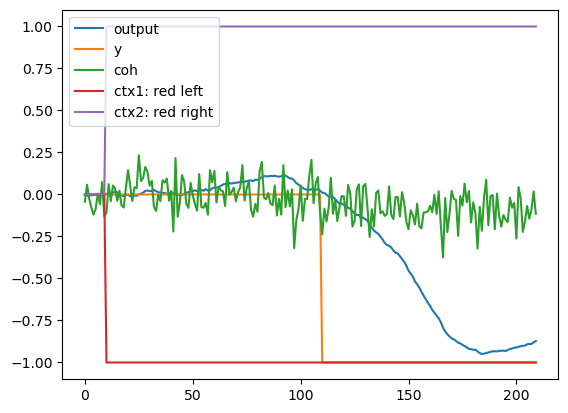

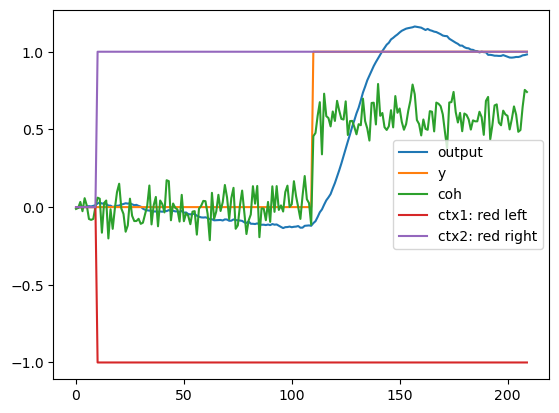

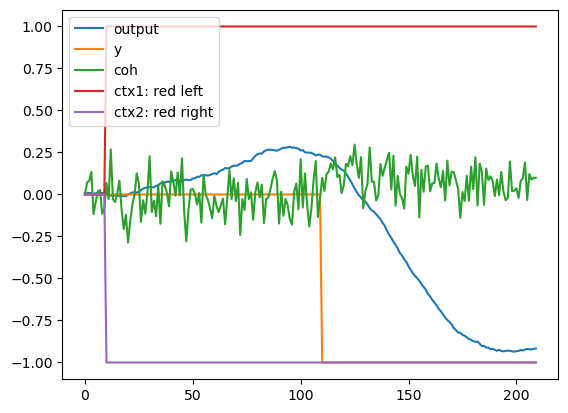

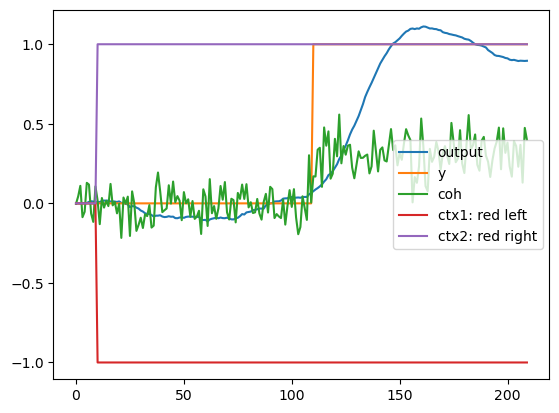

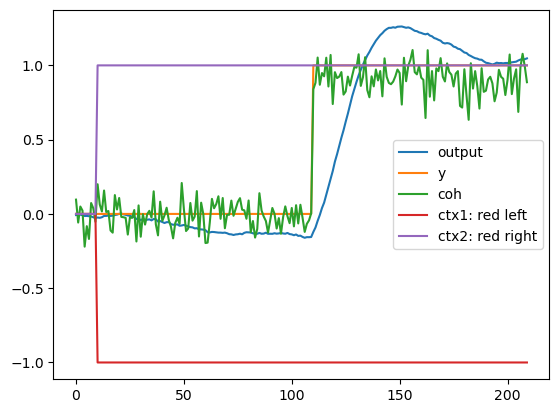

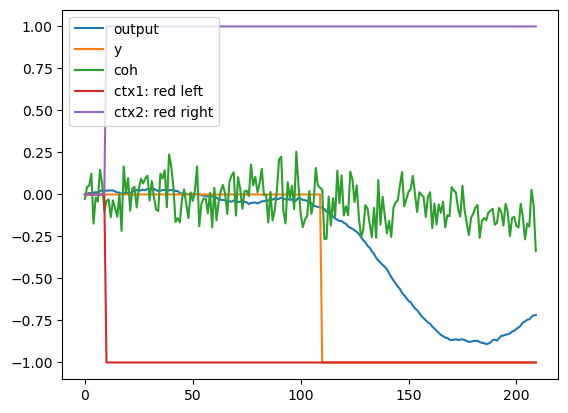

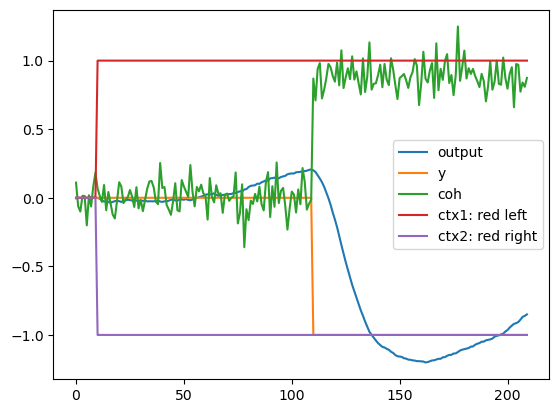

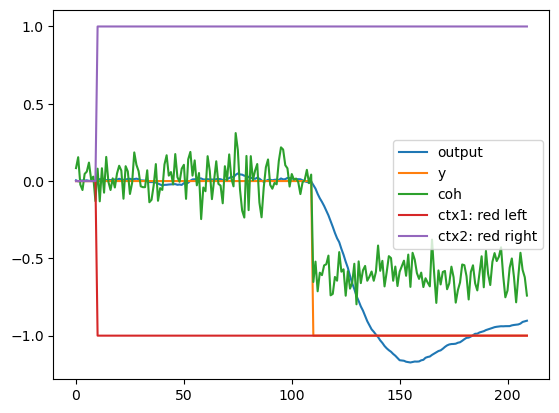

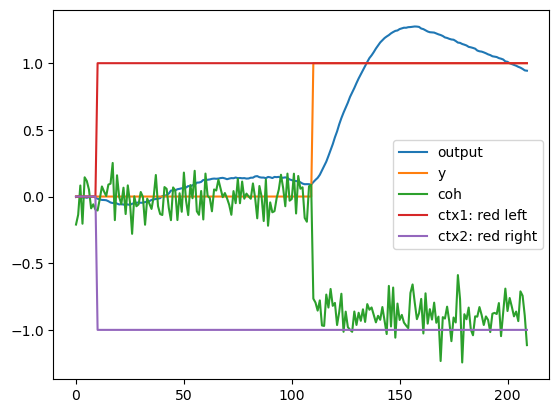

In [6]:
out = out.cpu()
y_val = y_val.cpu()
x_val = x_val.cpu()


for n in range(1, 10):
    plt.figure()
    aa = out.detach().numpy()
    plt.plot(aa[n,:,:], label = 'output')
    plt.plot(y_val[n,:,:], label = 'y')

    plt.plot(x_val[n,:,0], label = 'coh')
    plt.plot(x_val[n,:,1], label = 'ctx1: red left')
    plt.plot(x_val[n,:,2], label = 'ctx2: red right')

    plt.legend()
    plt.show()

# plot psth

In [37]:
traj = traj.cpu()
decisions = decisions.cpu()

traj1 = traj.detach().numpy()

traj1 = np.maximum(traj1, 0)

decisions1 = decisions.detach().numpy()

tfRL = traj1[np.logical_and(decisions1 == -1, cohAll_val > 0),:,:]
tfRR = traj1[np.logical_and(decisions1 == 1, cohAll_val > 0),:,:]
tfGL = traj1[np.logical_and(decisions1 == -1, cohAll_val < 0),:,:]
tfGR = traj1[np.logical_and(decisions1 == 1, cohAll_val < 0),:,:]

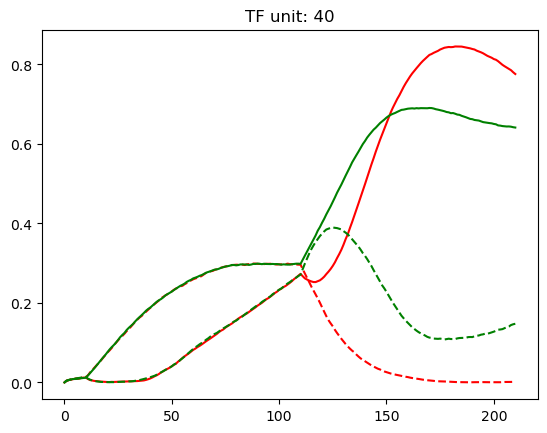

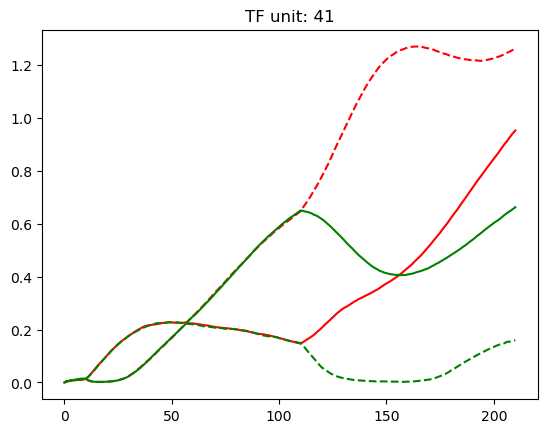

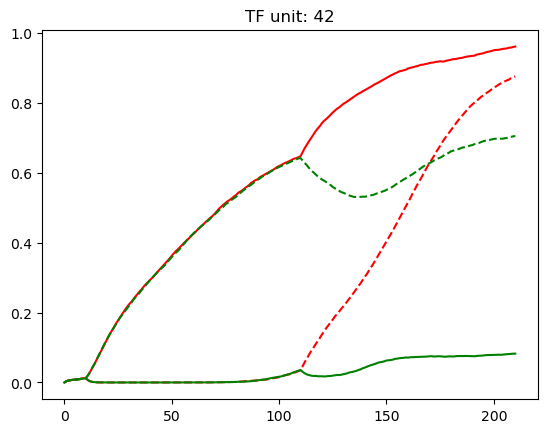

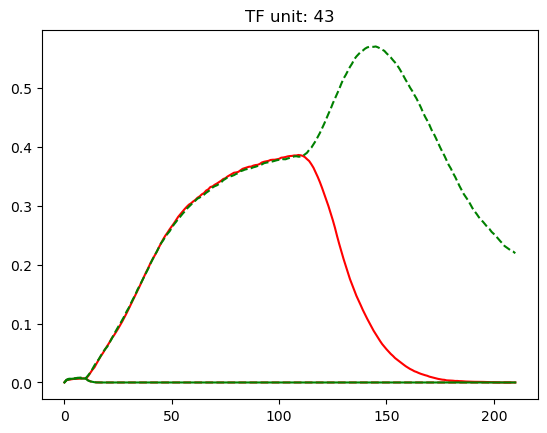

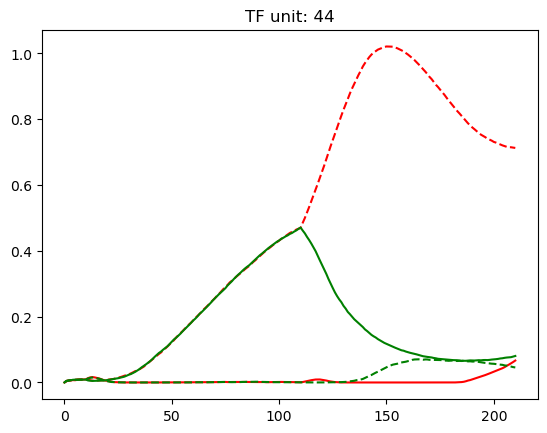

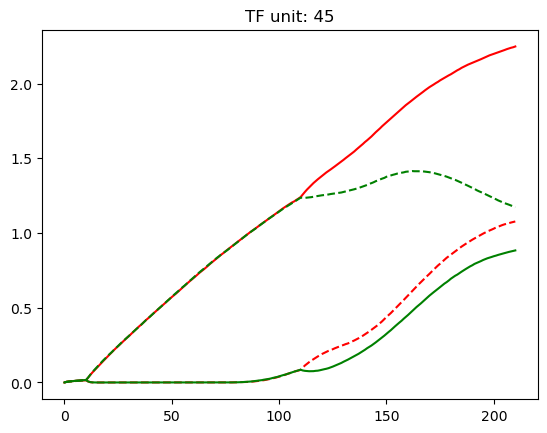

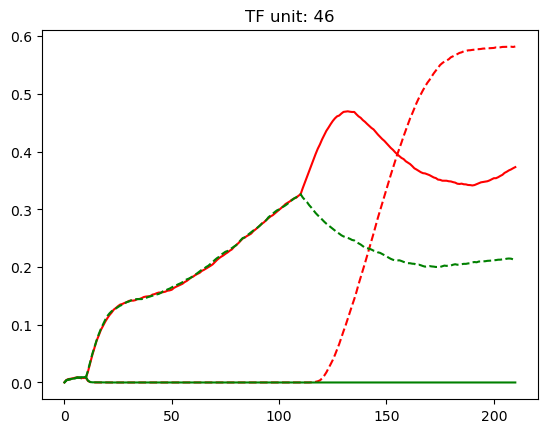

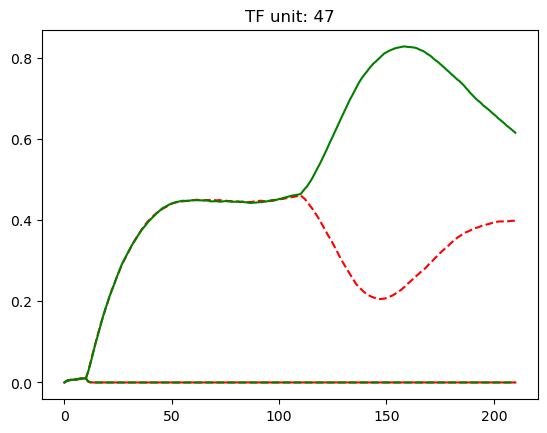

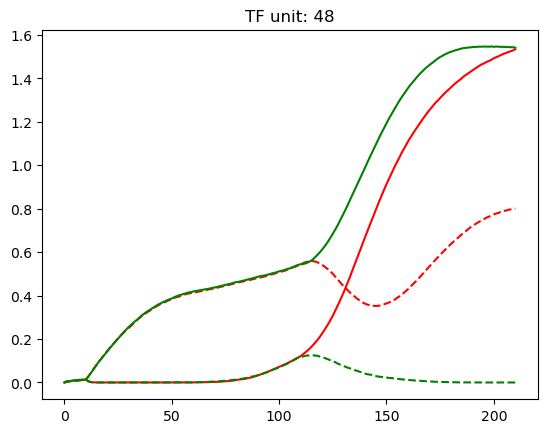

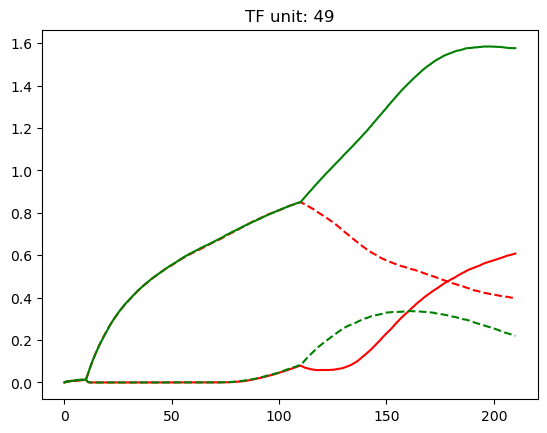

In [38]:
for n in range(40,50):
    plt.figure()
    plt.plot(np.mean(tfRL,axis = 0)[:,n], 'r-')
    plt.plot(np.mean(tfRR,axis = 0)[:,n], 'r--')
    plt.plot(np.mean(tfGL,axis = 0)[:,n], 'g-')
    plt.plot(np.mean(tfGR,axis = 0)[:,n], 'g--')
    plt.title("TF unit: " + str(n))
    

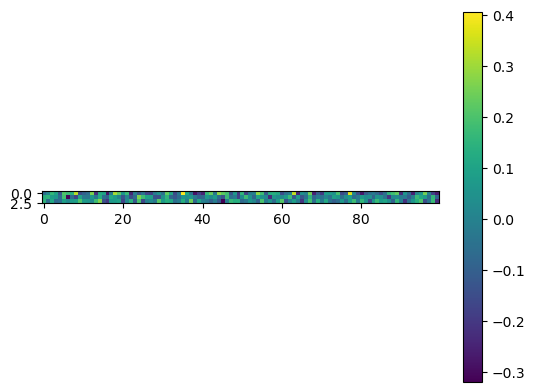

In [11]:
a = net.wi_full.cpu()
a = a.detach().numpy()
plt.imshow(a)
plt.colorbar()

In [12]:
# save the model
# torch.save(net.state_dict(), f'../models/TFnew_{size}.pt')

# train low-rank RNN

In [36]:
# load a full-rank RNN
import sys
sys.path.append('../')

from low_rank_rnns.test_modules_vanilla import *

from low_rank_rnns import TF, stats, plotting as plot, helpers, rankone, ranktwo, clustering

from matplotlib import pyplot as plt
# %matplotlib notebook

size = 100
noise_std = 1e-2
alpha = .1
lr = 1e-3


net = FullRankRNN(3, size, 1, noise_std, alpha)
net.load_state_dict(torch.load(f'../models/TFnew_{size}.pt', map_location='cpu'))

x_train, y_train, mask_train, cohAll_train, x_val, y_val, mask_val, cohAll_val = TF.generate_checker_data(5000)

loss, acc, out, decisions, target_decisions, traj = TF.test_checker(net, x_val, y_val, mask_val)
print(f'loss={loss:.3f}, acc={acc:.3f}')

loss=0.186, acc=1.000


In [28]:
# define some parameters
# hidden_size: # units in low-rank RNN (should match that in full-rank RNN)
hidden_size = 100
rank = 15

In [29]:
# you have to save model for full-rank RNN, then use that to train low-rank RNN 



# reduce the rank of connectivity matrix 
wi_init = net.wi_full.detach()
wo_init = net.wo_full.detach() * hidden_size
print(wo_init.std())
wrec = net.wrec.detach().cpu().numpy()
u, s, v = np.linalg.svd(wrec)
m_init = torch.from_numpy(s[:rank] * u[:, :rank]).to(device=net.wrec.device) * sqrt(hidden_size)
n_init = torch.from_numpy(v[:rank, :].transpose()).to(device=net.wrec.device) * sqrt(hidden_size)
print(m_init.std())
print(n_init.std())

print(m_init.shape)
print(n_init.shape)

tensor(5.4747)
tensor(1.8248)
tensor(1.0003)
torch.Size([100, 15])
torch.Size([100, 15])


In [30]:
x_train, y_train, mask_train, cohAll_train, x_val, y_val, mask_val, cohAll_val = TF.generate_checker_data(5000)


In [31]:


# We see that the rank-1 network 
net_lo = LowRankRNN(3, hidden_size, 1, noise_std, alpha, rank=rank, wi_init=wi_init, wo_init=wo_init, m_init=m_init, n_init=n_init)

train(net_lo, x_train, y_train, mask_train, n_epochs=50, lr=lr, batch_size=100, keep_best=True, cuda=True, clip_gradient=1, early_stop=0.2)
x_val, y_val, mask_val = map_device([x_val, y_val, mask_val], net_lo)
# out = net_lo.forward(x_val)
# print("Final loss: {:.3f}".format(loss_mse(out, y_val, mask_val)))

loss, acc, out, decisions, target_decisions, traj = TF.test_checker(net_lo, x_val, y_val, mask_val)
print(f'loss={loss:.3f}, acc={acc:.3f}')



Training...
initial loss: 0.707
epoch 0:  loss=0.630  (took 7.39 s) *
epoch 1:  loss=0.494  (took 7.34 s) *
epoch 2:  loss=0.406  (took 7.30 s) *
epoch 3:  loss=0.366  (took 7.54 s) *
epoch 4:  loss=0.337  (took 7.54 s) *
epoch 5:  loss=0.310  (took 7.54 s) *
epoch 6:  loss=0.295  (took 7.50 s) *
epoch 7:  loss=0.279  (took 7.52 s) *
epoch 8:  loss=0.267  (took 7.53 s) *
epoch 9:  loss=0.255  (took 7.42 s) *
epoch 10:  loss=0.244  (took 7.57 s) *
epoch 11:  loss=0.232  (took 7.56 s) *
epoch 12:  loss=0.220  (took 7.49 s) *
epoch 13:  loss=0.212  (took 7.48 s) *
epoch 14:  loss=0.204  (took 7.31 s) *
epoch 15:  loss=0.193  (took 7.32 s) *
loss=0.188, acc=0.998


In [ ]:
# save the low-rank model

# torch.save(net.state_dict(), f'../models/TFnew_rank{rank}.pt')

# Plot psth

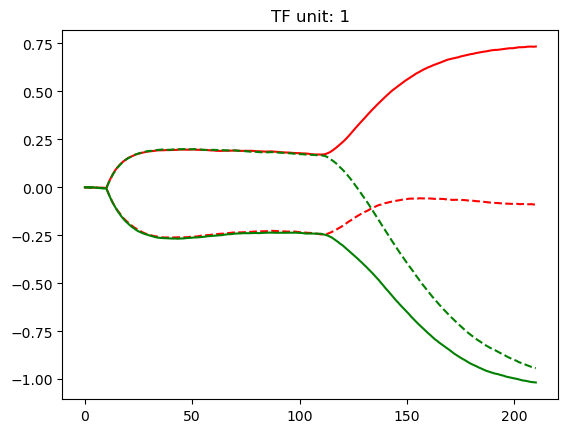

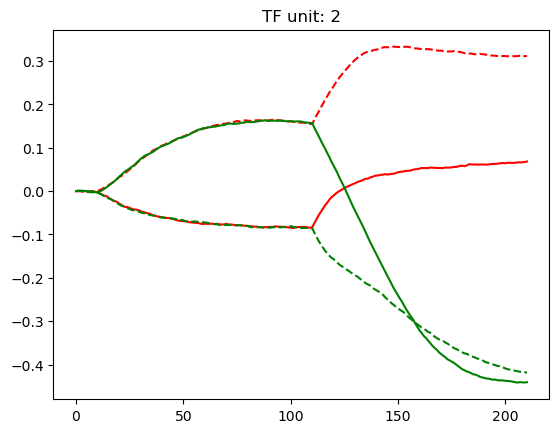

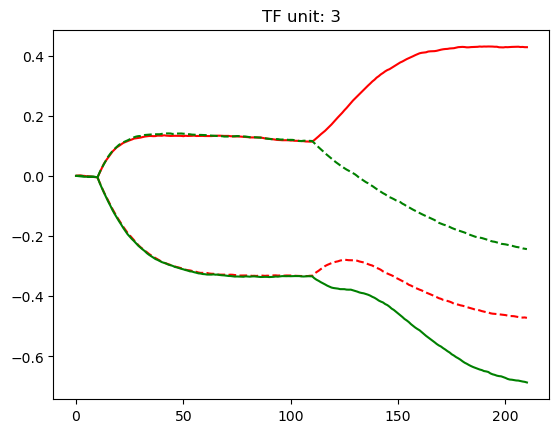

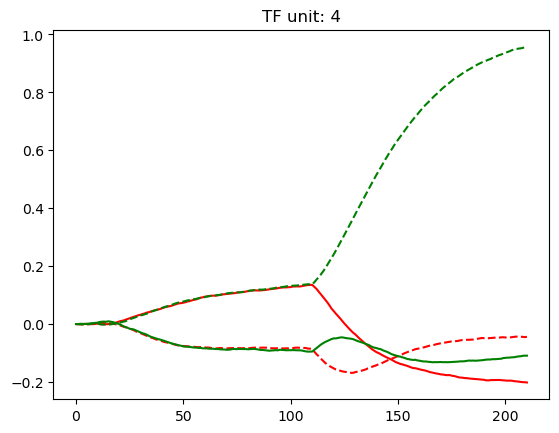

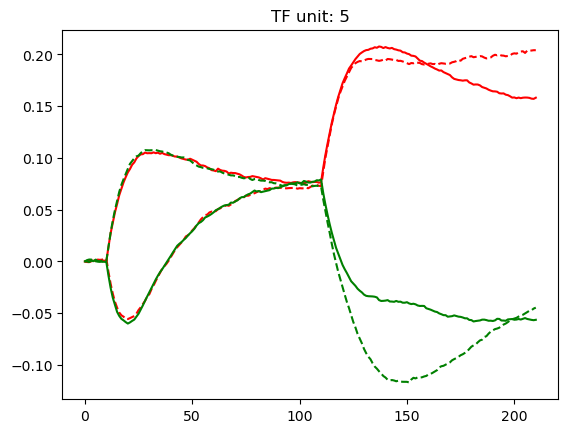

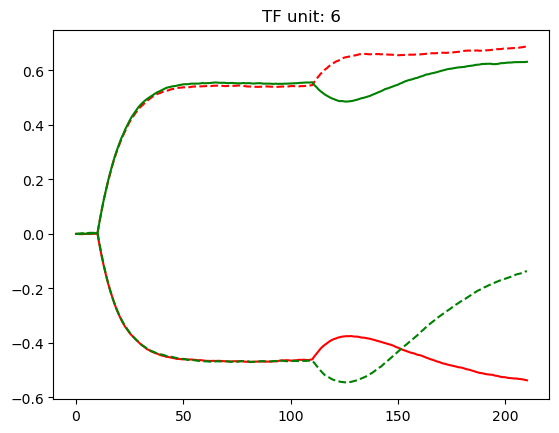

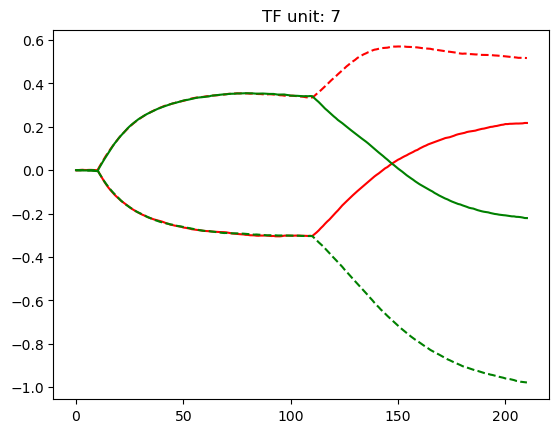

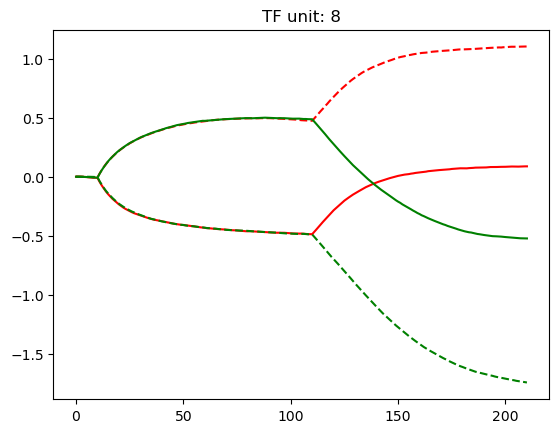

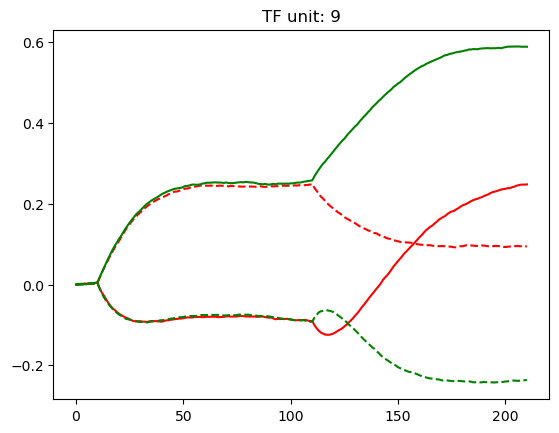

In [32]:


traj = traj.cpu()
decisions = decisions.cpu()

traj1 = traj.detach().numpy()

# traj1 = np.maximum(traj1, 0)

decisions1 = decisions.detach().numpy()

tfRL = traj1[np.logical_and(decisions1 == -1, cohAll_val > 0),:,:]
tfRR = traj1[np.logical_and(decisions1 == 1, cohAll_val > 0),:,:]
tfGL = traj1[np.logical_and(decisions1 == -1, cohAll_val < 0),:,:]
tfGR = traj1[np.logical_and(decisions1 == 1, cohAll_val < 0),:,:]

for n in range(1,10):
    plt.figure()
    plt.plot(np.mean(tfRL,axis = 0)[:,n], 'r-')
    plt.plot(np.mean(tfRR,axis = 0)[:,n], 'r--')
    plt.plot(np.mean(tfGL,axis = 0)[:,n], 'g-')
    plt.plot(np.mean(tfGR,axis = 0)[:,n], 'g--')
    plt.title("TF unit: " + str(n))

In [39]:
# umap 

import umap

a = np.mean(tfRL,axis = 0)
b = np.mean(tfRR,axis = 0)
c = np.mean(tfGL,axis = 0)
d = np.mean(tfGR,axis = 0)

psth = np.concatenate((a,b,c,d), axis=0) # error!

psth.shape

(844, 100)

/home/tianwang/anaconda3/envs/pyt/lib/python3.10/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


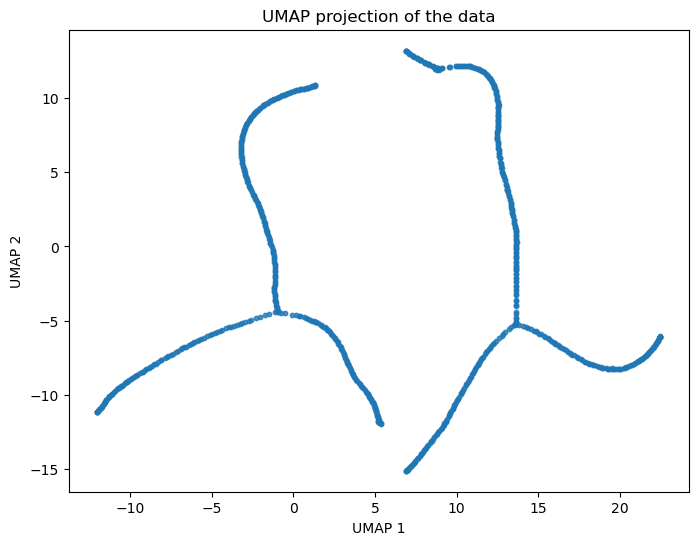

In [40]:
reducer = umap.UMAP(n_neighbors=15, min_dist=0.1, n_components=2, random_state=42)
embedding = reducer.fit_transform(psth)  # shape will be (844, 2)

# Step 2: Plot the result
plt.figure(figsize=(8, 6))
plt.scatter(embedding[:, 0], embedding[:, 1], s=10, alpha=0.8)
plt.title("UMAP projection of the data")
plt.xlabel("UMAP 1")
plt.ylabel("UMAP 2")
plt.show()



/home/tianwang/anaconda3/envs/pyt/lib/python3.10/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


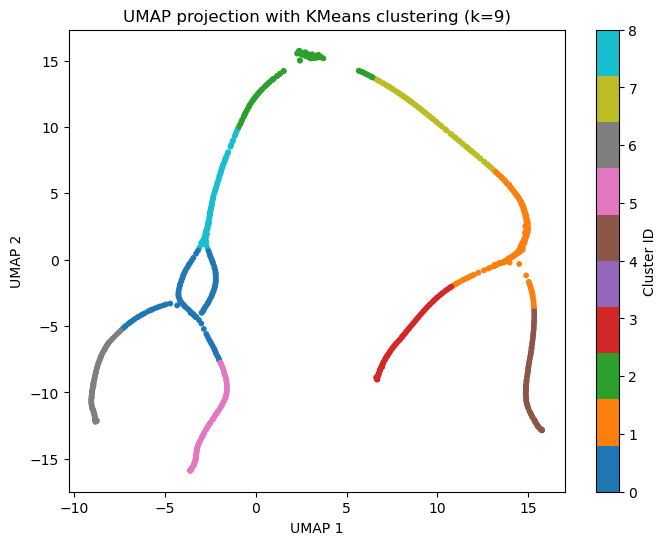

In [35]:
import numpy as np
import umap
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

# Step 1: UMAP dimensionality reduction
reducer = umap.UMAP(n_neighbors=15, min_dist=0.1, n_components=2, random_state=42)
embedding = reducer.fit_transform(psth)  # data: (844, 100)

# Step 2: Try different K for KMeans and pick best using silhouette score
scores = []
range_k = range(2, 10)
for k in range_k:
    km = KMeans(n_clusters=k, random_state=42)
    labels = km.fit_predict(embedding)
    score = silhouette_score(embedding, labels)
    scores.append(score)

# Step 3: Choose best K
best_k = range_k[np.argmax(scores)]
kmeans = KMeans(n_clusters=best_k, random_state=42)
cluster_labels = kmeans.fit_predict(embedding)

# Step 4: Plot UMAP with cluster coloring
plt.figure(figsize=(8, 6))
plt.scatter(embedding[:, 0], embedding[:, 1], c=cluster_labels, cmap='tab10', s=10)
plt.title(f"UMAP projection with KMeans clustering (k={best_k})")
plt.xlabel("UMAP 1")
plt.ylabel("UMAP 2")
plt.colorbar(label='Cluster ID')
plt.show()

# full-tank vs low-rank

In [1]:
# load a full-rank RNN
import sys
sys.path.append('../')

from low_rank_rnns.test_modules_vanilla import *

from low_rank_rnns import TF, stats, plotting as plot, helpers, rankone, ranktwo, clustering

from matplotlib import pyplot as plt
# %matplotlib notebook

size = 100
noise_std = 1e-2
alpha = .1
lr = 1e-3
rank = 5

# # load model
x_train, y_train, mask_train, cohAll_train, x_val, y_val, mask_val, cohAll_val = TF.generate_checker_data(5000)

net_lo = LowRankRNN(3, size, 1, noise_std, alpha, rank=rank)
net_lo.load_state_dict(torch.load(f'../models/TFnew_rank{rank}.pt', map_location='cpu'))


loss, acc, _, _, _, _ = TF.test_checker(net_lo, x_val, y_val, mask_val)
print(f'loss={loss:.3f}, acc={acc:.3f}')



RuntimeError: Error(s) in loading state_dict for LowRankRNN:
	Missing key(s) in state_dict: "wrec_mask", "wi_mask", "wo_mask", "m", "n". 
	Unexpected key(s) in state_dict: "wrec". 

In [11]:

net_lo.cpu().svd_reparametrization()

# n: low-rank Wrec connectivity vector n
n = net_lo.n.cpu().detach().numpy()


# m: low-rank Wrec connectivity vector m
m = net_lo.m.cpu().detach().numpy()


In [12]:
trajLow = np.zeros((4, tfRL.shape[1], tfRL.shape[2]))
trajLow[0,:,:] = np.mean(tfRL,axis = 0)
trajLow[1,:,:] =np.mean(tfRR,axis = 0)
trajLow[2,:,:] =np.mean(tfGL,axis = 0)
trajLow[3,:,:] =np.mean(tfGR,axis = 0)

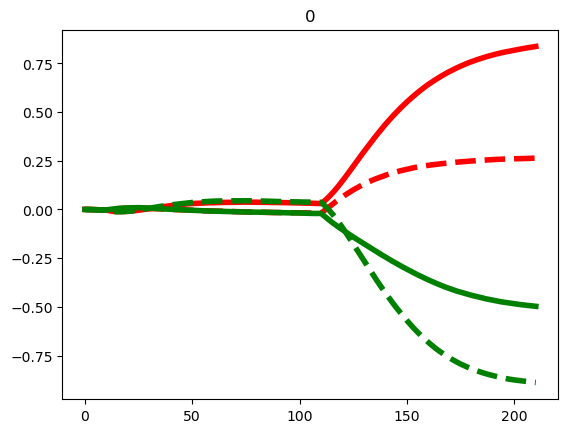

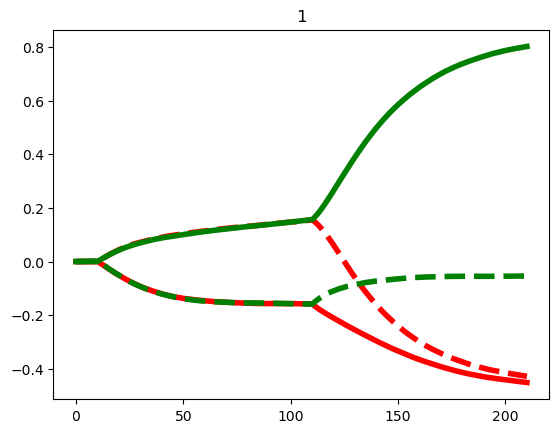

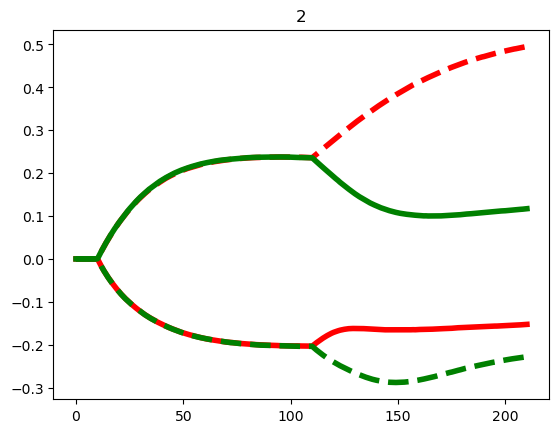

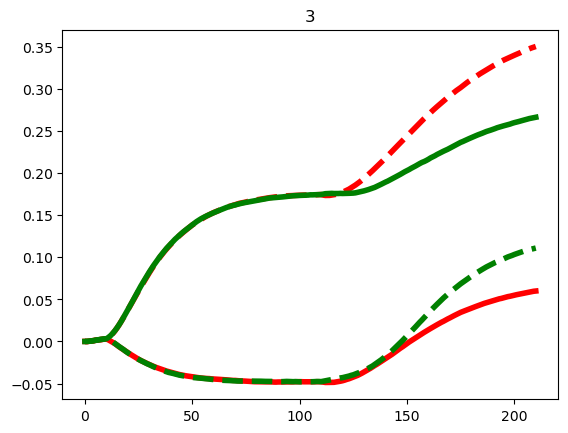

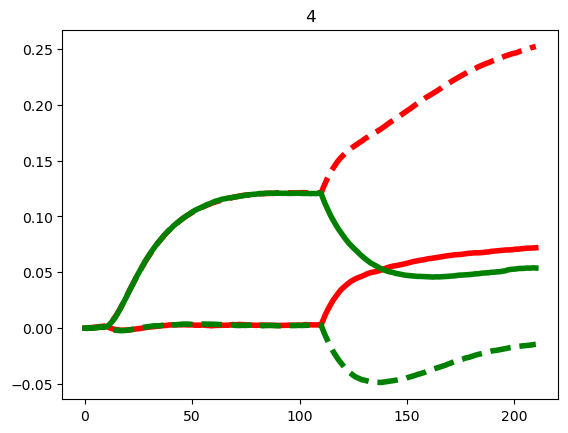

In [13]:
colors = ['red', 'red', 'green', 'green']
lineStyle = ['-', '--', '-', '--']


def projLow(trajLow, m, plotTraj): 
    # project low rank rnn traj on m vector
    kap = np.zeros((trajLow.shape[0], trajLow.shape[1], m.shape[1]))
    for ii in range(m.shape[1]):
        kap[:,:,ii] = trajLow @ m[:,ii] / size
    
    
    colors = ['red', 'red', 'green', 'green']
    lineStyle = ['-', '--', '-', '--']

    if plotTraj:
        for jj in range(kap.shape[2]):
            plt.figure()
            for i in range(4):
                plt.plot(kap[i,:,jj], c=colors[i], lw=4, ls=lineStyle[i])
            plt.title(jj)
            plt.show()

    return kap



kap = projLow(trajLow, m, True)




In [ ]:
# low rank RNN PCA 

def areaPCA(trajLow):
    TOn = 10
    COn = 100
    
    pca = plot.pca_cumvar(trajLow, n_components=10)
    plt.ylim(0, 1.02)
    plt.axhline(1, ls='--', c='gray')
    plt.show()
    
    labels = ['RL', 'RR', 'GL', 'GR']
    
    ax1 = pca.components_[0]
    ax2 = pca.components_[1]
    ax3 = pca.components_[2]
    ax4 = pca.components_[3]
    
    k1 = trajLow @ ax1
    k2 = trajLow @ ax2
    k3 = trajLow @ ax3
    k4 = trajLow @ ax4
    
    plt.figure()
    for i in range(4):
    #      plt.plot(kap1[i], kap2[i], c=colors[i], lw=4, ls = lineStyle[i])
        plt.plot(k1[i], c=colors[i], lw=4, ls=lineStyle[i])
    plt.show()
    
    plt.figure()
    for i in range(4):
    #      plt.plot(kap1[i], kap2[i], c=colors[i], lw=4, ls = lineStyle[i])
        plt.plot(k2[i], c=colors[i], lw=4, ls=lineStyle[i])
    plt.show()
    
    plt.figure()
    for i in range(4):
        plt.plot(k3[i], c=colors[i], lw=4, ls = lineStyle[i], label=labels[i])
    plt.show()
    
    plt.figure()
    for i in range(4):
        plt.plot(k4[i], c=colors[i], lw=4, ls = lineStyle[i], label=labels[i])
    plt.show()
    
    # 3D pca plot
    from mpl_toolkits.mplot3d import Axes3D
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')

    for i in range(4):
        plt.plot(k1[i], k2[i], k3[i], c=colors[i], lw=4, ls = lineStyle[i])
        ax.scatter(k1[i, TOn], k2[i, TOn], k3[i, TOn], c='black',
                marker='.', s=400)
        ax.scatter(k1[i, COn], k2[i, COn], k3[i, COn], c= 'magenta',
                marker='.', s=400)
    ax.axis('equal')


areaPCA(trajLow)


# fields

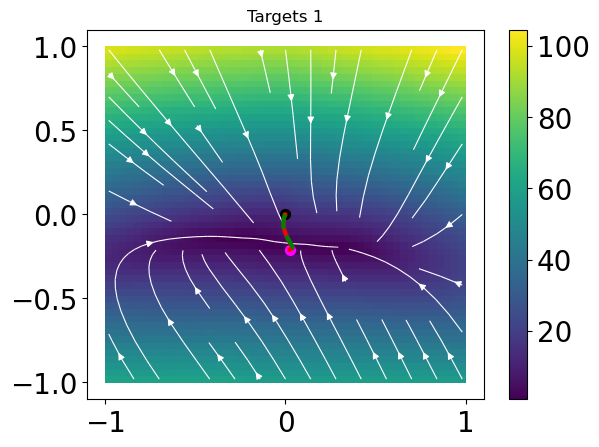

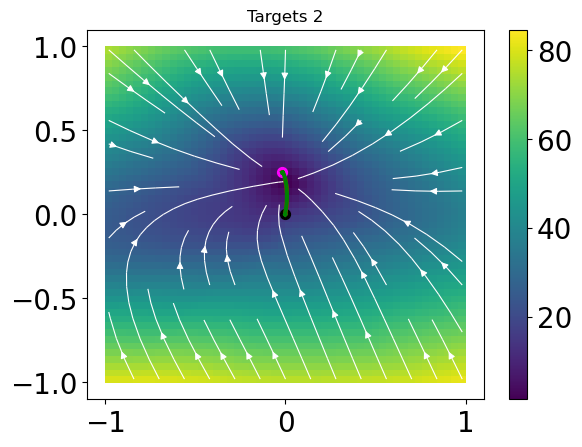

In [44]:
TOn = 10
COn = 100

# only target epoch
dim1 = 0
dim2 = 2
kap1T = kap[:,:COn, dim1]
kap2T = kap[:,:COn, dim2]
plt.rcParams['xtick.labelsize'] = 20
plt.rcParams['ytick.labelsize'] = 20
[ax, mappable] = ranktwo.plot_field(net_lo, m[:, dim1], m[:,dim2], -1, 1, -1, 1, input=torch.tensor([0.,1, -1]))
mappable.set_cmap('viridis')
plt.colorbar(mappable)


plt.plot(kap1T[0], kap2T[0], c=colors[0], lw=3, ls=lineStyle[0])
plt.plot(kap1T[3], kap2T[3], c=colors[3], lw=3, ls=lineStyle[3])
plt.scatter(kap[0, TOn,dim1], kap[0, TOn, dim2], c= 'k',
    marker='.', s=200)  
plt.scatter(kap[0, COn, dim1], kap[0, COn, dim2], c= 'magenta',
    marker='.', s=200) 
        
plt.title('Targets 1')        
# # plt.savefig('TFT1.pdf', bbox_inches='tight')
        
plt.show()

# target 1 epoch 
[ax, mappable] = ranktwo.plot_field(net_lo, m[:, dim1], m[:,dim2], -1, 1, -1, 1, input=torch.tensor([0.,-1, 1]))
mappable.set_cmap('viridis')
plt.colorbar(mappable)

plt.plot(kap1T[1], kap2T[1], c=colors[0], lw=3, ls=lineStyle[1])
plt.plot(kap1T[2], kap2T[2], c=colors[3], lw=3, ls=lineStyle[2])
plt.scatter(kap[1, TOn, dim1], kap[1, TOn, dim2], c= 'k',
    marker='.', s=200)  
plt.scatter(kap[1, COn, dim1], kap[1, COn, dim2], c= 'magenta',
    marker='.', s=200) 
        
plt.title('Targets 2')        
# # plt.savefig('TFT2.pdf', bbox_inches='tight')
        
plt.show()



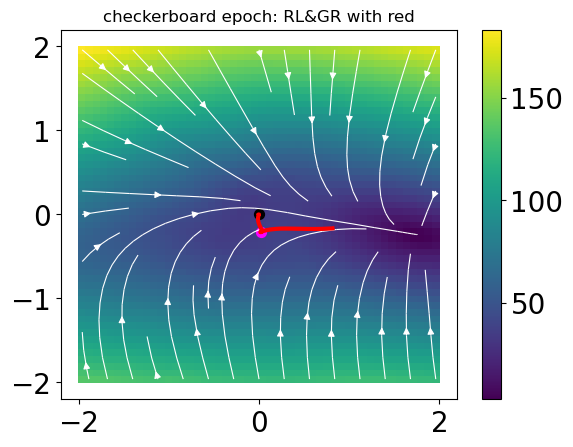

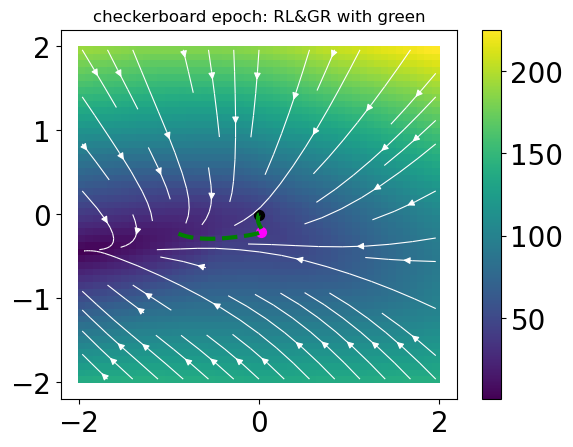

In [45]:

# checkerboard epoch
kap1C = kap[:,COn:, dim1]
kap3C = kap[:,COn:, dim2]
plt.rcParams['xtick.labelsize'] = 20
plt.rcParams['ytick.labelsize'] = 20
[ax, mappable] = ranktwo.plot_field(net_lo, m[:, dim1], m[:,dim2], -2, 2, -2, 2, input=torch.tensor([0.9,1, -1]))

mappable.set_cmap('viridis')
plt.colorbar(mappable)


plt.plot(kap[0,:,dim1], kap[0,:,dim2], c=colors[0], lw=3, ls=lineStyle[0])
plt.scatter(kap[0, TOn, dim1], kap[0, TOn, dim2], c= 'k',
    marker='.', s=200)  
plt.scatter(kap[0, COn, dim1], kap[0, COn, dim2], c= 'magenta',
    marker='.', s=200) 

plt.title('checkerboard epoch: RL&GR with red')        
# plt.savefig('TFT1R.pdf', bbox_inches='tight')
        
plt.show()






# checkerboard epoch

[ax, mappable] = ranktwo.plot_field(net_lo, m[:, dim1], m[:,dim2], -2, 2, -2, 2, input=torch.tensor([-0.9,1, -1]))

mappable.set_cmap('viridis')
plt.colorbar(mappable)

plt.plot(kap[3,:,dim1], kap[3,:,dim2], c=colors[3], lw=3, ls=lineStyle[3])
plt.scatter(kap[3, TOn, dim1], kap[3, TOn, dim2], c= 'k',
    marker='.', s=200)  
plt.scatter(kap[3, COn, dim1], kap[3, COn, dim2], c= 'magenta',
    marker='.', s=200) 


plt.title('checkerboard epoch: RL&GR with green')        
# plt.savefig('TFT1G.pdf', bbox_inches='tight')
        
plt.show()



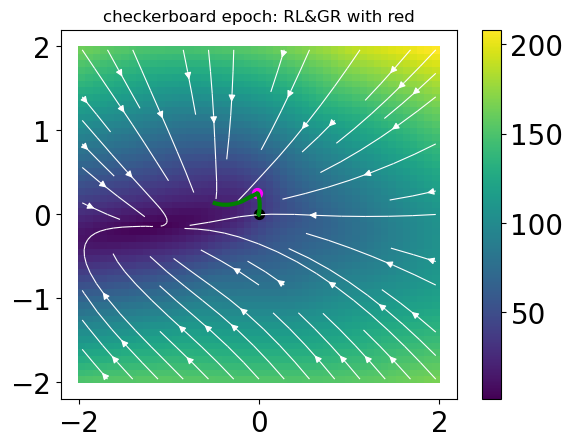

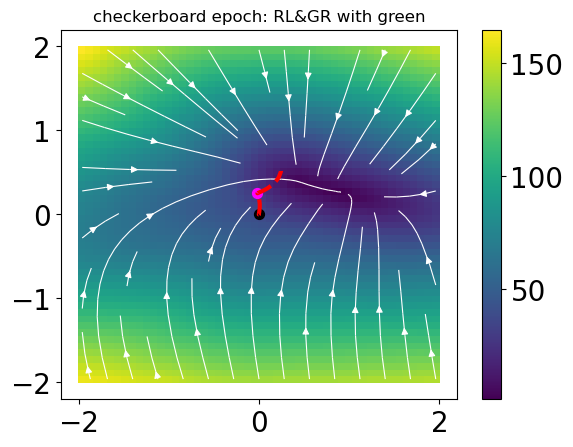

In [46]:

# checkerboard epoch
kap1C = kap[:,COn:, dim1]
kap3C = kap[:,COn:, dim2]
plt.rcParams['xtick.labelsize'] = 20
plt.rcParams['ytick.labelsize'] = 20
[ax, mappable] = ranktwo.plot_field(net_lo, m[:, dim1], m[:,dim2], -2, 2, -2, 2, input=torch.tensor([-0.9,-1, 1]))

mappable.set_cmap('viridis')
plt.colorbar(mappable)


plt.plot(kap[2,:,dim1], kap[2,:,dim2], c=colors[2], lw=3, ls=lineStyle[2])
plt.scatter(kap[2, TOn, dim1], kap[2, TOn, dim2], c= 'k',
    marker='.', s=200)  
plt.scatter(kap[2, COn, dim1], kap[2, COn, dim2], c= 'magenta',
    marker='.', s=200) 

plt.title('checkerboard epoch: RL&GR with red')        
# plt.savefig('TFT1R.pdf', bbox_inches='tight')
        
plt.show()






# checkerboard epoch

[ax, mappable] = ranktwo.plot_field(net_lo, m[:, dim1], m[:,dim2], -2, 2, -2, 2, input=torch.tensor([0.9,-1, 1]))

mappable.set_cmap('viridis')
plt.colorbar(mappable)

plt.plot(kap[1,:,dim1], kap[1,:,dim2], c=colors[1], lw=3, ls=lineStyle[1])
plt.scatter(kap[1, TOn, dim1], kap[1, TOn, dim2], c= 'k',
    marker='.', s=200)  
plt.scatter(kap[1, COn, dim1], kap[1, COn, dim2], c= 'magenta',
    marker='.', s=200) 


plt.title('checkerboard epoch: RL&GR with green')        
# plt.savefig('TFT1G.pdf', bbox_inches='tight')
        
plt.show()
